# Apply machine learning models to CTD data
Created by Ivan Lima on Tue Nov  2 2021 10:47:31 -0400

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os, datetime, warnings
print('Last updated on {}'.format(datetime.datetime.now().ctime()))

Last updated on Mon Dec  6 16:17:56 2021


In [2]:
sns.set_theme(context='paper', style='ticks', palette='tab10', rc={'figure.dpi':100, 'figure.figsize':[5, 5], 'axes.grid':True})
pd.options.display.max_columns = 50
warnings.filterwarnings('ignore')

In [3]:
# turn off GridSearchCV annoying warnings when n_jobs=-1
import sys, warnings
warnings.filterwarnings('ignore')
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

## Read bottle & satellite data 

In [4]:
df_bottle = pd.read_csv('data/bottle_satellite_data_clean.csv', parse_dates=['Date'], index_col=0)
df_bottle.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2601 entries, 0 to 3039
Data columns (total 45 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   X.x                  2601 non-null   int64         
 1   X.y                  2601 non-null   int64         
 2   DOI                  2601 non-null   object        
 3   EXPOCODE             1466 non-null   object        
 4   Accession            101 non-null    float64       
 5   Cruise_ID            2022 non-null   object        
 6   Date                 2601 non-null   datetime64[ns]
 7   Year                 2601 non-null   int64         
 8   Month                2601 non-null   int64         
 9   Day                  2601 non-null   int64         
 10  Time_UTC             2521 non-null   object        
 11  Latitude             2601 non-null   float64       
 12  Longitude            2601 non-null   float64       
 13  Depth_bottom         1341 non-nul

## Select input features and split data into training and test sets 

In [5]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV

# Set input and output variables
features = ['Depth', 'bottom_depth', 'Temperature', 'Salinity', 'pCO2_monthave', 'SLA', 'SST_hires', 'KD490']
targets  = ['DIC', 'TA']

X = df_bottle[features].values
Y = df_bottle[targets].values

# Split data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42)

## Tune & train neural network regression model 

Linear models and neural networks are very tied to the scale and distribution of each feature. Therefore, we rescale input features so they have mean=0 and std=1.

Best cross-validation score: 0.9570
Best parameters: {'mlpregressor__activation': 'relu', 'mlpregressor__alpha': 0.01, 'mlpregressor__hidden_layer_sizes': [400]}
Best estimator: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpregressor',
                 MLPRegressor(alpha=0.01, hidden_layer_sizes=[400],
                              random_state=42, solver='lbfgs'))])
Training set score: 0.9601
Test set score:     0.9534
Final model cross-validation mean score: 0.9192


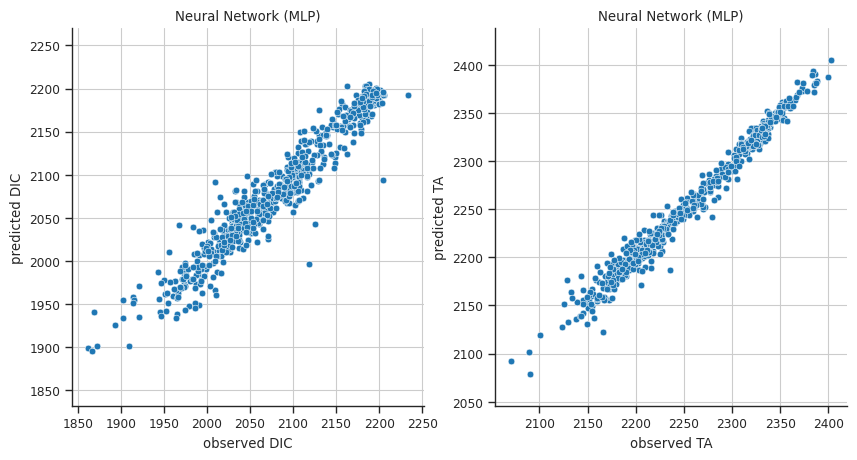

In [6]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline, make_pipeline

pipe = make_pipeline(StandardScaler(), MLPRegressor(solver='lbfgs', random_state=42))

param_grid = {'mlpregressor__hidden_layer_sizes': [[100,], [200,], [300,], [400,]],
              'mlpregressor__activation' : ['logistic', 'tanh', 'relu'],
              'mlpregressor__alpha': [0.0001, 0.001, 0.01]}
gs_nnr = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1)
gs_nnr.fit(X_train, Y_train);

print('Best cross-validation score: {:.4f}'.format(gs_nnr.best_score_))
print('Best parameters: {}'.format(gs_nnr.best_params_))
print('Best estimator: {}'.format(gs_nnr.best_estimator_))

print('Training set score: {:.4f}'.format(gs_nnr.score(X_train, Y_train)))
print('Test set score:     {:.4f}'.format(gs_nnr.score(X_test, Y_test)))

scores = cross_val_score(gs_nnr.best_estimator_, X, Y, cv=5, n_jobs=-1)
print('Final model cross-validation mean score: {:.4f}'.format(scores.mean()))

Y_pred = gs_nnr.predict(X_test)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
_ = sns.scatterplot(x=Y_test[:,0], y=Y_pred[:,0], ax=ax0)
_ = sns.scatterplot(x=Y_test[:,1], y=Y_pred[:,1], ax=ax1)
_ = ax0.set(xlabel='observed DIC', ylabel='predicted DIC', title='Neural Network (MLP)')
_ = ax1.set(xlabel='observed TA', ylabel='predicted TA', title='Neural Network (MLP)')
ax0.axis('equal')
ax1.axis('equal')
sns.despine(fig)

## Read merged CTD & satellite data 

In [7]:
df_ctd = pd.read_hdf('data/CombinedCTD_satellite_1981-2021.h5', key='df_ctd_sat')
df_ctd = df_ctd.rename(columns={'pCO2_year':'pCO2_yearhave', 'pCO2_month':'pCO2_monthave'})
df_ctd = df_ctd[~df_ctd[features].isnull().any(axis=1)]
print('Total number of valid CTD points: {:,}\n'.format(len(df_ctd)))
df_ctd.info()

Total number of valid CTD points: 7,821,744

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7821744 entries, 3332461 to 14539801
Data columns (total 20 columns):
 #   Column         Dtype         
---  ------         -----         
 0   Cast           float64       
 1   Latitude       float64       
 2   Longitude      float64       
 3   Date           datetime64[ns]
 4   Depth          float64       
 5   Temperature    float64       
 6   Salinity       float64       
 7   Oxygen         float64       
 8   pCO2_yearhave  float64       
 9   pCO2_monthave  float64       
 10  Platform_Type  float64       
 11  Temp_flag      float64       
 12  Salt_flag      float64       
 13  DO_flag        float64       
 14  bottom_depth   int64         
 15  SLA            float64       
 16  SST            float64       
 17  SST_hires      float64       
 18  Chl            float64       
 19  KD490          float64       
dtypes: datetime64[ns](1), float64(18), int64(1)
memory usage: 1.

## Apply neural network model to merged CTD & satellite data

In [8]:
X_ctd = df_ctd[features].values
Y_ctd = gs_nnr.predict(X_ctd)
df_ctd['DIC'] = Y_ctd[:,0]
df_ctd['TA'] = Y_ctd[:,1]

## Write merged CTD & satellite data with DIC & TA to HDF5 file

In [9]:
yr_min, yr_max = df_ctd.Date.dt.year.min(), df_ctd.Date.dt.year.max()
outfile = 'data/CombinedCTD_satellite_bgc_sklearn_{}-{}.h5'.format(yr_min, yr_max)
print('writing {}'.format(outfile))
df_ctd.to_hdf(outfile, key='df_ctd', mode='w', complevel=9)

writing data/CombinedCTD_satellite_bgc_sklearn_2002-2019.h5


## Use 1/4 degree SST instead of high resolution SST

In [10]:
features2 = ['Depth', 'bottom_depth', 'Temperature', 'Salinity', 'pCO2_monthave', 'SLA', 'SST', 'KD490']

df_ctd = pd.read_hdf('data/CombinedCTD_satellite_1981-2021.h5', key='df_ctd_sat')
df_ctd = df_ctd.rename(columns={'pCO2_year':'pCO2_yearhave', 'pCO2_month':'pCO2_monthave'})
df_ctd = df_ctd[~df_ctd[features2].isnull().any(axis=1)]
print('Total number of valid CTD points: {:,}\n'.format(len(df_ctd)))
# df_ctd.info()

Total number of valid CTD points: 7,825,998



In [11]:
X_ctd = df_ctd[features2].values
Y_ctd = gs_nnr.predict(X_ctd)
df_ctd['DIC'] = Y_ctd[:,0]
df_ctd['TA'] = Y_ctd[:,1]

yr_min, yr_max = df_ctd.Date.dt.year.min(), df_ctd.Date.dt.year.max()
outfile = 'data/CombinedCTD_satellite_bgc_sklearn_{}-{}.h5'.format(yr_min, yr_max)
print('writing {}'.format(outfile))
df_ctd.to_hdf(outfile, key='df_ctd', mode='w', complevel=9)

writing data/CombinedCTD_satellite_bgc_sklearn_1998-2019.h5
